[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://bit.ly/open-data-04-coffee-store-input)

## 소상공인시장진흥공단 상가업소정보로 스타벅스, 이디야 위치 분석하기

* 이디야는 스타벅스 근처에 입점한다는 설이 있습니다. 과연 이디야와 스타벅스의 매장입지는 얼마나 차이가 날까요? 관련 기사를 읽고 구별로 이디야와 스타벅스의 매장을 기사와 유사하게 분석하고 시각화 해보면서 Python, Pandas, Numpy, Seaborn, Matplotlib, folium 을 통해 다양한 방법으로 표현해 봅니다..

### 다루는 내용
* 공공데이터를 활용해 텍스트 데이터 정제하고 원하는 정보 찾아내기
* 문자열에서 원하는 텍스트 추출하기
* 문자열을 활용한 다양한 분석 방법과 위치 정보 사용하기
* folium을 통한 위경도 데이터 시각화 이해하기

### 실습
* 텍스트 데이터 정제하기 -  대소문자로 섞여있는 상호명을 소문자로 변경하고 상호명 추출하기
* 텍스트 데이터에서 원하는 정보 추출하기 - 브랜드명 컬럼을 만들고 구별 매장 수 분석하기
* folium을 통해 지도에 분석한 내용을 표현하기 - CircleMarker와 choropleth 그리기


### 데이터셋
* https://www.data.go.kr/dataset/15012005/fileData.do
* 구별로 매장수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)
    * 이 링크에서도 다운로드가 가능합니다. https://drive.google.com/open?id=13j8-_XLdPe0pptsqu8-uyE-0Ym6V2jw5

### 관련기사
* [[비즈&빅데이터]스타벅스 '쏠림' vs 이디야 '분산'](http://news.bizwatch.co.kr/article/consumer/2018/01/19/0015)

## 필요한 라이브러리 불러오기

In [1]:
# 데이터 분석을 위해 pandas를, 수치계산을 위해 numpy를, 시각화를 위해 seaborn을 불러옵니다.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 구버전의 주피터 노트북에서 그래프가 보이는 설정
%matplotlib inline

## 시각화를 위한 한글 폰트 설정하기

In [2]:
# 한글폰트 설정
import koreanize_matplotlib

In [3]:
# 폰트가 선명하게 보이도록 retina 설정
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [4]:
# 한글폰트와 마이너스 폰트 설정 확인


## Google Colab 을 위한 코드
### Colab 에서 실행을 위한 코드

* 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리합니다.
* google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러옵니다.

In [5]:
# 폰트 설정이 잘 안 된다면 해당 셀의 마지막 줄 주석을 풀고 실행해 보세요.
# colab 사용시에도 아래 함수를 활용해 보세요.
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

# plt.rc("font", family=get_font_family())

### Colab 용 GoogleAuth 인증 
* 구글 드라이브에 있는 파일을 가져오기 위해 사용합니다.

In [6]:
# # 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # PyDrive client 인증
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [7]:
# # 공유 가능한 링크로 파일 가져오기
# url = 'https://drive.google.com/open?id=1e91PH_KRFxNXUsx8Hi-Q2vPiorCDsOP4'
# id = url.split('=')[1]
# print(id)
# downloaded = drive.CreateFile({'id':id}) 
# # data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
# %mkdir data
# downloaded.GetContentFile('data/상가업소정보_201912_01.csv')  

## 데이터 불러오기
* 공공데이터 포털 : https://www.data.go.kr/dataset/15012005/fileData.do
* 영상에 사용한 데이터셋 : http://bit.ly/open-data-set-folder (공공데이터포털에서 다운로드 받은 파일이 있습니다. 어떤 파일을 다운로드 받아야 될지 모르겠다면 여기에 있는 파일을 사용해 주세요.)

In [8]:
# 파일을 불러와 df 라는 변수에 담습니다.
# shape 를 통해 불러온 csv 파일의 크기를 확인합니다.

df = pd.read_csv('../data/market_info_2019.csv', sep="|")
df.head()

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,...,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,19905471,와라와라호프,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,...,1168010600106040000014378,대치상가,서울특별시 강남구 남부순환로 2933,135280,6280.0,NaN,1,NaN,127.061026,37.493922
1,19911397,커피빈코리아선릉로93길점,코리아선릉로93길점,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,...,1168010100106960042022041,NaN,서울특별시 강남구 선릉로93길 6,135080,6149.0,NaN,1,NaN,127.047883,37.505675
2,19911801,프로포즈,NaN,Q,음식,Q09,유흥주점,Q09A01,호프/맥주,I56219,...,1154510200101620001017748,NaN,서울특별시 금천구 가산로 34-6,153010,8545.0,NaN,1,NaN,126.899220,37.471711
3,19912201,싱싱커피&토스트,NaN,Q,음식,Q07,패스트푸드,Q07A10,토스트전문,I56192,...,2653010400105780000002037,산업용품유통상가,부산광역시 사상구 괘감로 37,617726,46977.0,NaN,1,26,128.980455,35.159774
4,19932756,가락사우나내스낵,NaN,F,생활서비스,F09,대중목욕탕/휴게,F09A02,사우나/증기탕/온천,S96121,...,1171010500102560005010490,NaN,서울특별시 송파구 가락로 71,138846,5690.0,NaN,1,NaN,127.104071,37.500249


### 데이터 미리보기

In [9]:
df.shape

(573680, 39)

### info 보기

In [10]:
# info 를 사용하면 데이터의 전체적인 정보를 볼 수 있습니다.
# 데이터의 사이즈, 타입, 메모리 사용량 등을 볼 수 있습니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     573680 non-null  int64  
 1   상호명        573679 non-null  object 
 2   지점명        76674 non-null   object 
 3   상권업종대분류코드  573680 non-null  object 
 4   상권업종대분류명   573680 non-null  object 
 5   상권업종중분류코드  573680 non-null  object 
 6   상권업종중분류명   573680 non-null  object 
 7   상권업종소분류코드  573680 non-null  object 
 8   상권업종소분류명   573680 non-null  object 
 9   표준산업분류코드   539290 non-null  object 
 10  표준산업분류명    539290 non-null  object 
 11  시도코드       573680 non-null  int64  
 12  시도명        573680 non-null  object 
 13  시군구코드      573680 non-null  int64  
 14  시군구명       573680 non-null  object 
 15  행정동코드      573680 non-null  int64  
 16  행정동명       573680 non-null  object 
 17  법정동코드      573680 non-null  int64  
 18  법정동명       573680 non-null  object 
 19  지번코드       573680 non-n

### 결측치 보기

<AxesSubplot:>

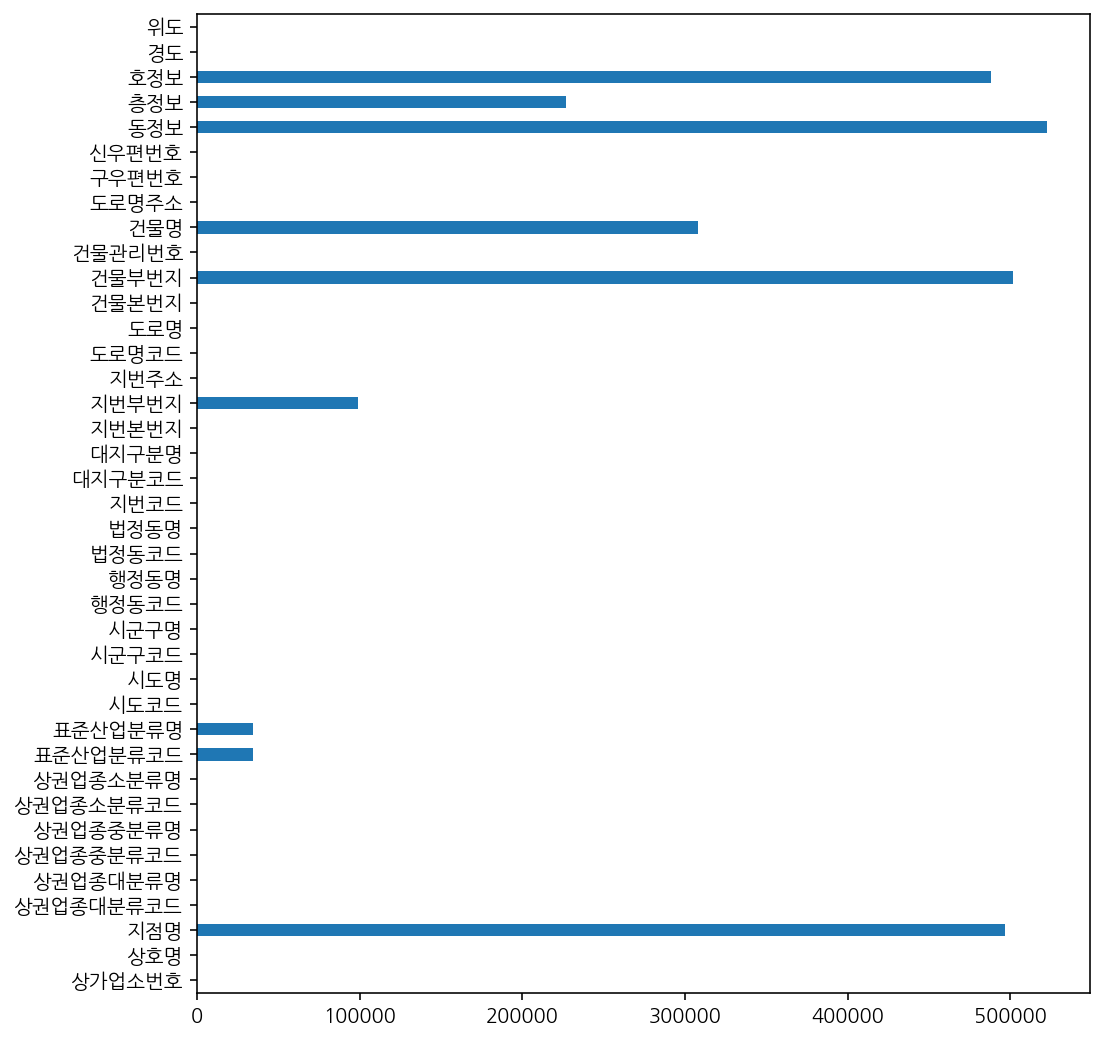

In [11]:
# isnull() 을 사용하면 데이터의 결측치를 볼 수 있습니다.
# 결측치는 True로 값이 있다면 False로 표시되는데 True 는 1과 같기 때문에 
# True 값을 sum()을 사용해서 더하게 되면 합계를 볼 수 있습니다.

df.isnull().sum().plot.barh(figsize=(8,9))

### 사용하지 않는 컬럼 제거하기

In [12]:
# drop을 하는 방법도 있지만 사용할 컬럼만 따로 모아서 보는 방법도 있습니다.
# 여기에서는 사용할 컬럼만 따로 모아서 사용합니다.
columns = ['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
           '시도명', '시군구명', '행정동명', '법정동명', '도로명주소', 
           '경도', '위도']
print(df.shape)
df = df[columns].copy()
print(df.shape)

(573680, 39)
(573680, 11)


In [13]:
# 제거 후 메모리 사용량 보기

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573680 entries, 0 to 573679
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   상호명       573679 non-null  object 
 1   상권업종대분류명  573680 non-null  object 
 2   상권업종중분류명  573680 non-null  object 
 3   상권업종소분류명  573680 non-null  object 
 4   시도명       573680 non-null  object 
 5   시군구명      573680 non-null  object 
 6   행정동명      573680 non-null  object 
 7   법정동명      573680 non-null  object 
 8   도로명주소     573680 non-null  object 
 9   경도        573680 non-null  float64
 10  위도        573680 non-null  float64
dtypes: float64(2), object(9)
memory usage: 48.1+ MB


## 색인으로 서브셋 가져오기

### 서울만 따로 보기

In [14]:
# 시도명이 서울로 시작하는 데이터만 봅니다.
# 또, df_seoul 이라는 변수에 결과를 저장합니다.
# 새로운 변수에 데이터프레임을 할당할 때 copy()를 사용하는 것을 권장합니다.
df_seoul = df[df['시도명']=='서울특별시'].copy()
df_seoul.head()

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도
0,와라와라호프,음식,유흥주점,호프/맥주,서울특별시,강남구,대치1동,대치동,서울특별시 강남구 남부순환로 2933,127.061026,37.493922
1,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 선릉로93길 6,127.047883,37.505675
2,프로포즈,음식,유흥주점,호프/맥주,서울특별시,금천구,독산3동,독산동,서울특별시 금천구 가산로 34-6,126.899220,37.471711
4,가락사우나내스낵,생활서비스,대중목욕탕/휴게,사우나/증기탕/온천,서울특별시,송파구,석촌동,석촌동,서울특별시 송파구 가락로 71,127.104071,37.500249
5,초밥왕,음식,일식/수산물,음식점-초밥전문,서울특별시,송파구,잠실6동,신천동,서울특별시 송파구 올림픽로 293-19,127.102490,37.515149


### 일부 텍스트가 들어가는 데이터만 가져오기
* 상호명에서 브랜드명을 추출합니다.
* 대소문자가 섞여 있을 수도 있기 때문에 대소문자를 변환해 줍니다.
* 오타를 방지하기 위해 스타벅스의 영문명은 STARBUCKS, 이디야는 EDIYA 입니다.

* https://pandas.pydata.org/docs/user_guide/text.html#testing-for-strings-that-match-or-contain-a-pattern

In [15]:
# 문자열의 소문자로 변경하는 메소드를 사용합니다.
# "상호명_소문자" 컬럼을 만듭니다.

df_seoul['상호명_소문자'] = df_seoul['상호명'].str.lower().copy()
df_seoul.head()

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도,상호명_소문자
0,와라와라호프,음식,유흥주점,호프/맥주,서울특별시,강남구,대치1동,대치동,서울특별시 강남구 남부순환로 2933,127.061026,37.493922,와라와라호프
1,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,강남구,역삼1동,역삼동,서울특별시 강남구 선릉로93길 6,127.047883,37.505675,커피빈코리아선릉로93길점
2,프로포즈,음식,유흥주점,호프/맥주,서울특별시,금천구,독산3동,독산동,서울특별시 금천구 가산로 34-6,126.899220,37.471711,프로포즈
4,가락사우나내스낵,생활서비스,대중목욕탕/휴게,사우나/증기탕/온천,서울특별시,송파구,석촌동,석촌동,서울특별시 송파구 가락로 71,127.104071,37.500249,가락사우나내스낵
5,초밥왕,음식,일식/수산물,음식점-초밥전문,서울특별시,송파구,잠실6동,신천동,서울특별시 송파구 올림픽로 293-19,127.102490,37.515149,초밥왕


In [16]:
# ediya 를 "상호명_소문자" 컬럼으로 가져옵니다.
# '상호명_소문자'컬럼으로 '이디야|ediya' 를 가져와 갯수를 세어봅니다.
# loc[행]
# loc[행, 열]

df_seoul[df_seoul['상호명_소문자'].str.contains("이디야|이디아|ediya")].shape

(543, 12)

In [17]:
# 상호명에서 스타벅스만 가져옵니다.
# 상호명은 소문자로 변경해 준 컬럼을 사용합니다.
# 스타벅스|starbucks 의 "상호명_소문자"로 갯수를 세어봅니다.
df_seoul[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks')].shape

(506, 12)

In [18]:
# '상호명_소문자'컬럼으로  '스타벅스|starbucks|이디야|이디아|ediya'를 가져와 df_cafe 변수에 담습니다.
df_cafe = df_seoul[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks|이디야|이디아|ediya')].copy()
df_cafe.shape

(1049, 12)

In [19]:
# ~은 not을 의미합니다. 스타벅스가 아닌 데이터는 이디야로 넣어주어도 되지만
# 아래 코드처럼 결측치를 이디야로 채워줘도 괜찮습니다.
# df_cafe.loc[~df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'

df_cafe.loc[df_cafe['상호명_소문자'].str.contains('스타벅스|starbucks'), "브랜드명"] = "스타벅스"
df_cafe['브랜드명']

1104      스타벅스
1675       NaN
2023      스타벅스
2770      스타벅스
2957       NaN
          ... 
567090    스타벅스
567828    스타벅스
568636     NaN
570096    스타벅스
571052    스타벅스
Name: 브랜드명, Length: 1049, dtype: object

In [20]:
# 스타벅스를 제외한 데이터는 이디야이기 때문에 이디야로 브랜드명을 만듭니다.
# df_cafe["브랜드명"].fillna("이디야")

df_cafe['브랜드명'] = df_cafe['브랜드명'].fillna('이디야')
df_cafe.head()

,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도명,시군구명,행정동명,법정동명,도로명주소,경도,위도,상호명_소문자,브랜드명
1104,스타벅스,음식,커피점/카페,커피전문점/카페/다방,서울특별시,용산구,이태원1동,이태원동,서울특별시 용산구 이태원로 188,126.994781,37.534303,스타벅스,스타벅스
1675,이디야커피,음식,커피점/카페,커피전문점/카페/다방,서울특별시,영등포구,신길1동,신길동,서울특별시 영등포구 영등포로 353,126.918062,37.515118,이디야커피,이디야
2023,스타벅스종로3가점,음식,커피점/카페,커피전문점/카페/다방,서울특별시,종로구,종로1.2.3.4가동,종로3가,서울특별시 종로구 종로 113-1,126.990207,37.570585,스타벅스종로3가점,스타벅스
2770,스타벅스,음식,커피점/카페,커피전문점/카페/다방,서울특별시,서초구,잠원동,잠원동,서울특별시 서초구 강남대로 581,127.019763,37.513663,스타벅스,스타벅스
2957,이디야커피,음식,커피점/카페,커피전문점/카페/다방,서울특별시,구로구,구로3동,구로동,서울특별시 구로구 디지털로32길 43,126.897870,37.484385,이디야커피,이디야


In [21]:
# df_cafe에 담긴 상호명','브랜드명'으로 미리보기를 합니다.
df_cafe[['상호명','브랜드명']]

,상호명,브랜드명
1104,스타벅스,스타벅스
1675,이디야커피,이디야
2023,스타벅스종로3가점,스타벅스
2770,스타벅스,스타벅스
2957,이디야커피,이디야
...,...,...
567090,스타벅스,스타벅스
567828,스타벅스,스타벅스
568636,이디야커피,이디야
570096,스타벅스,스타벅스


In [22]:
df_cafe['브랜드명'].value_counts()

이디야     543
스타벅스    506
Name: 브랜드명, dtype: int64

### 시각화
#### 분류별 countplot 그리기

<AxesSubplot:>

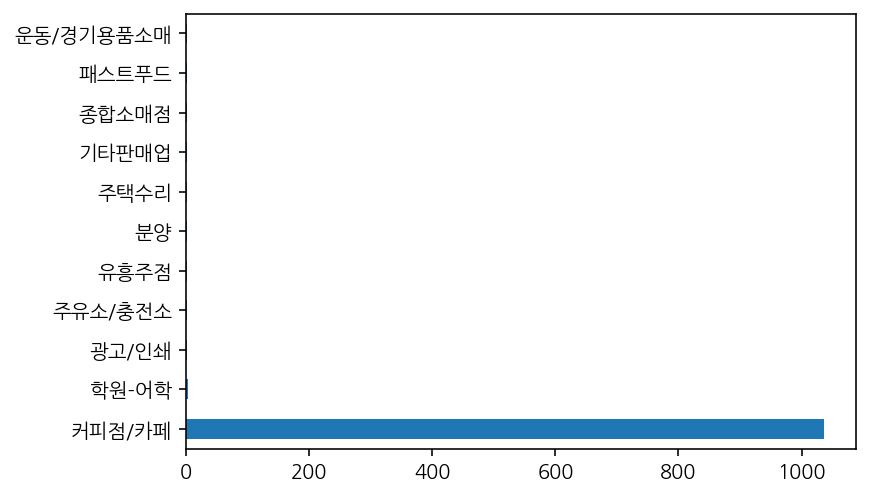

In [23]:
# "상권업중분류명"을 countplot 으로 시각화하고 분류 혹은 데이터가 잘못 색인된 데이터가 있는지 봅니다.

df_cafe['상권업종중분류명'].value_counts().plot.barh()

In [24]:
df_cafe = df_cafe[df_cafe['상권업종중분류명'] == '커피점/카페'].copy()
df_cafe.shape

(1036, 13)

In [25]:
# 브랜드명으로 각 카페의 갯수를 세어봅니다.
df_cafe['브랜드명'].value_counts()

이디야     532
스타벅스    504
Name: 브랜드명, dtype: int64

<AxesSubplot:xlabel='브랜드명', ylabel='count'>

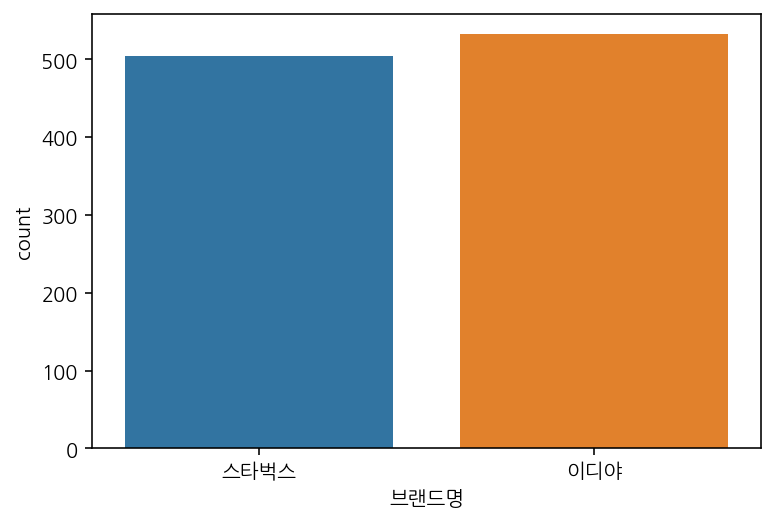

In [26]:
# 브랜드명을 막대그래프로 그려봅니다.
sns.countplot(data=df_cafe, x='브랜드명')

<AxesSubplot:xlabel='시군구명', ylabel='count'>

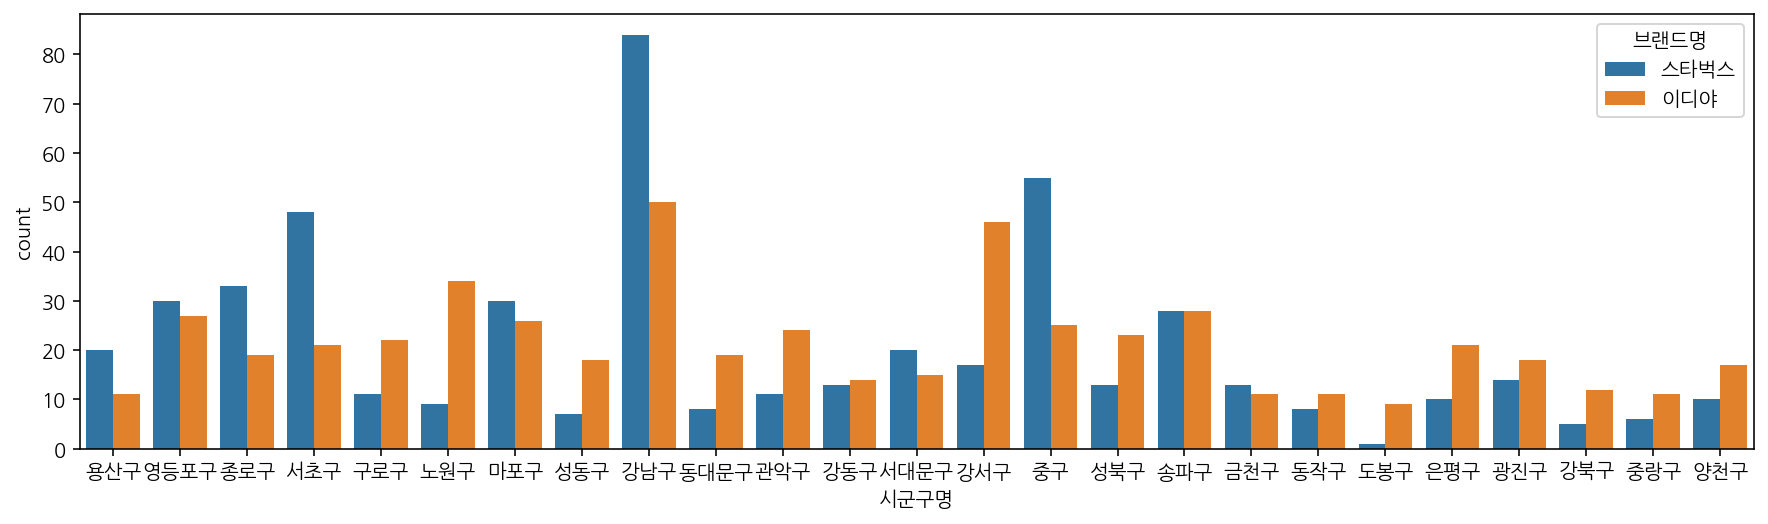

In [27]:
# 시군구명을 막대그래프로 그려봅니다.
plt.figure(figsize=(15,4))
sns.countplot(data=df_cafe, x='시군구명', hue='브랜드명')

#### scatterplot 그리기
* https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-plot

<AxesSubplot:xlabel='경도', ylabel='위도'>

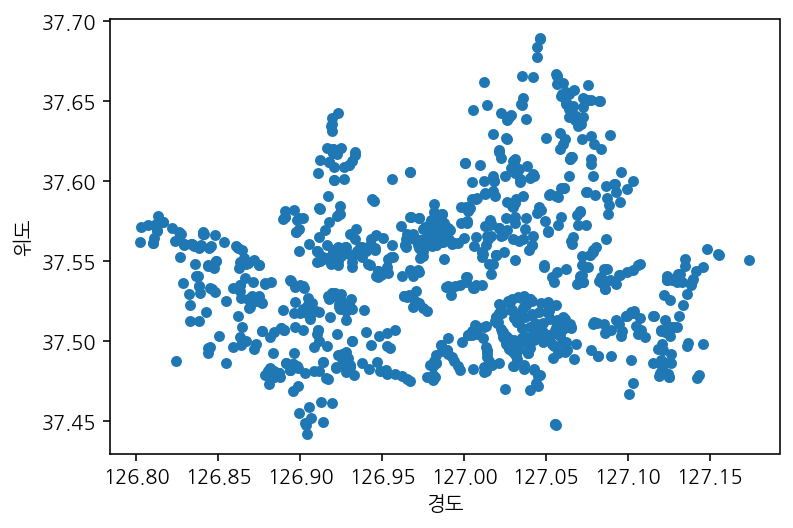

In [28]:
# pandas로 scatterplot을 그려봅니다.
df_cafe[['위도','경도']].plot.scatter(x='경도', y='위도')

<AxesSubplot:xlabel='경도', ylabel='위도'>

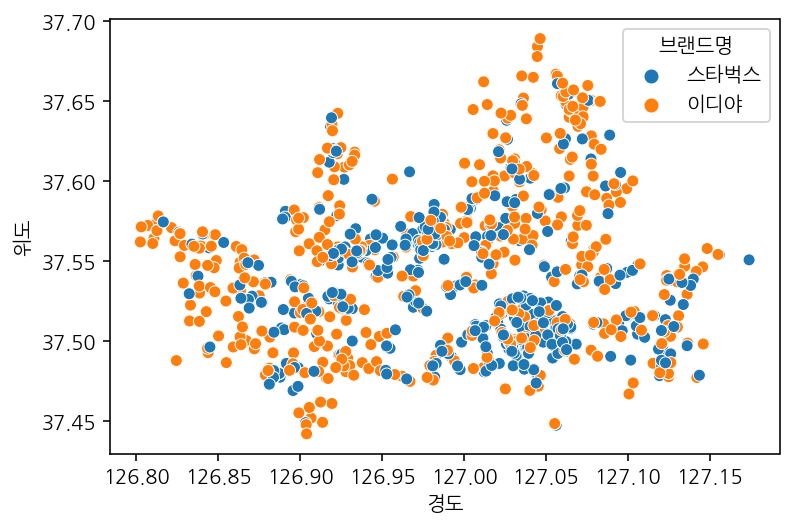

In [29]:
# seaborn의 scatterplot 으로 hue에 브랜드명을 지정해서 시각화 합니다.

sns.scatterplot(data=df_cafe, x='경도', y='위도', hue = '브랜드명')

#### jointplot 그리기

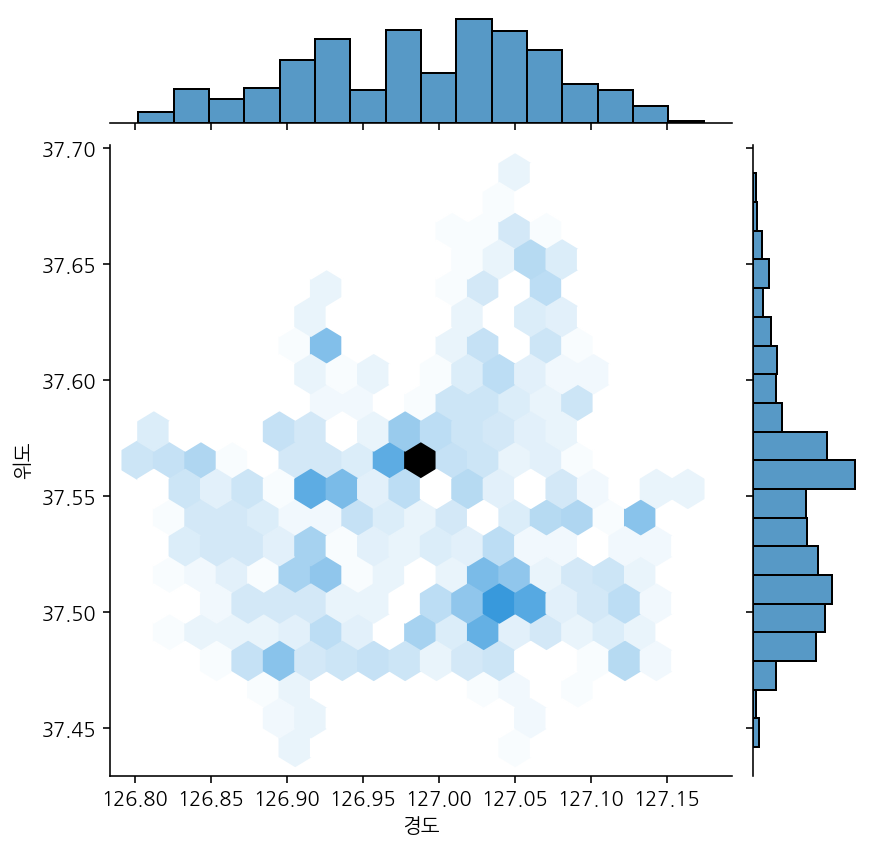

In [30]:
# jointplot 그리기

sns.jointplot(data=df_cafe,x='경도',y='위도',kind="hex")

## 구별 브랜드별 점포수
### groupby 와 pivot_table 로 구별 스타벅스, 이디야 매장 수 구하기
#### groupby 로 구별 매장수 구하기

In [31]:
# 구별로 브랜드별 점포수를 구합니다.
# groupby 를 사용하면 구별로 그룹화 해서 점포수를 구할 수 있습니다.
# 그룹화한 결과를 df_cafe_vs 변수에 담아서 재사용합니다.

df_cafe_vs = df_cafe.groupby(['시군구명','브랜드명'])['상호명'].count()
df_cafe_vs.head()
# groupby를 이용하면 데이터가 데이터프레임 형태로 나오지 않는다
# 따라서 일단 변수명에 저장하여 이용한다

시군구명  브랜드명
강남구   스타벅스    84
      이디야     50
강동구   스타벅스    13
      이디야     14
강북구   스타벅스     5
Name: 상호명, dtype: int64

In [32]:
# groupby를 이용해서 구한 값을 데이터 형태로 만드는 방법
df_cafe_vs.to_frame().head()

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    50
강동구  스타벅스   13
     이디야    14
강북구  스타벅스    5

In [33]:
# reset_index 로 인덱스를 컬럼으로 만듭니다.
df_cafe_vs = df_cafe_vs.reset_index()
df_cafe_vs.head()

,시군구명,브랜드명,상호명
0,강남구,스타벅스,84
1,강남구,이디야,50
2,강동구,스타벅스,13
3,강동구,이디야,14
4,강북구,스타벅스,5


In [34]:
# groupby '시군구명', '브랜드명' 으로 갯수를 세어봅니다.
# 결과에 대한 데이터프레임 컬럼명을 ['구', '브랜드명', '매장수'] 로 지정합니다.

df_cafe_vs.columns=['구','브랜드명','매장수']
df_cafe_vs.head()

,구,브랜드명,매장수
0,강남구,스타벅스,84
1,강남구,이디야,50
2,강동구,스타벅스,13
3,강동구,이디야,14
4,강북구,스타벅스,5


#### pivot_table 로 구별 매장수 구하기

In [35]:
# 위에서 했던 과정을 pivot_table 로 구합니다.
# pivot 과 pivot_table의 가장 큰 차이는 pivot은 연산을 할 수 없다

pivot = pd.pivot_table(data=df_cafe,index=['시군구명','브랜드명'], values='상호명',
               aggfunc='count')
pivot.head()

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    50
강동구  스타벅스   13
     이디야    14
강북구  스타벅스    5

In [36]:
# 특정 구 데이터만 가져와서 보기

pivot.loc['강남구']

,상호명
브랜드명,
스타벅스,84
이디야,50


### 막대그래프로 시각화 하기

<AxesSubplot:xlabel='구', ylabel='매장수'>

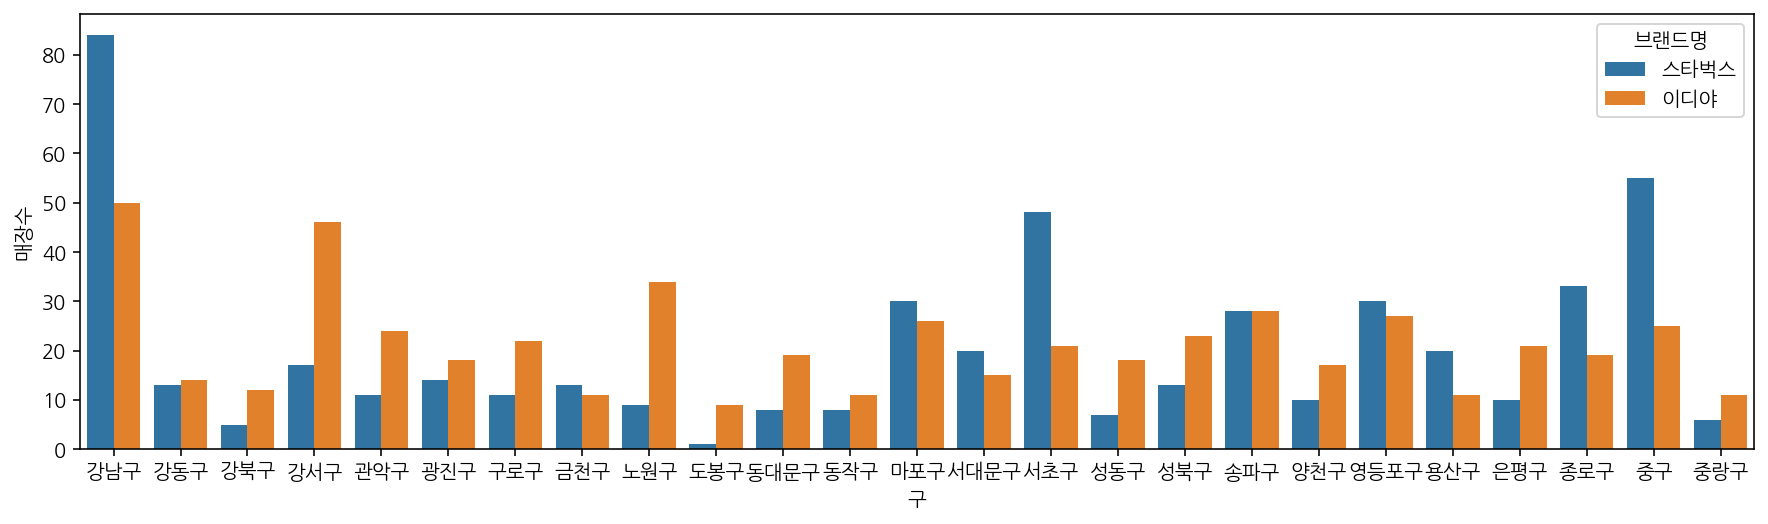

In [37]:
# seaborn의 barplot 을 활용해 구별 매장수를 시각화 합니다.
plt.figure(figsize=(15,4))
sns.barplot(data=df_cafe_vs,x='구',y='매장수',hue='브랜드명')

* 브랜드명을 컬럼으로 만들기
* unstack 이해하기 : https://pandas.pydata.org/docs/user_guide/reshaping.html

<AxesSubplot:xlabel='시군구명,브랜드명'>

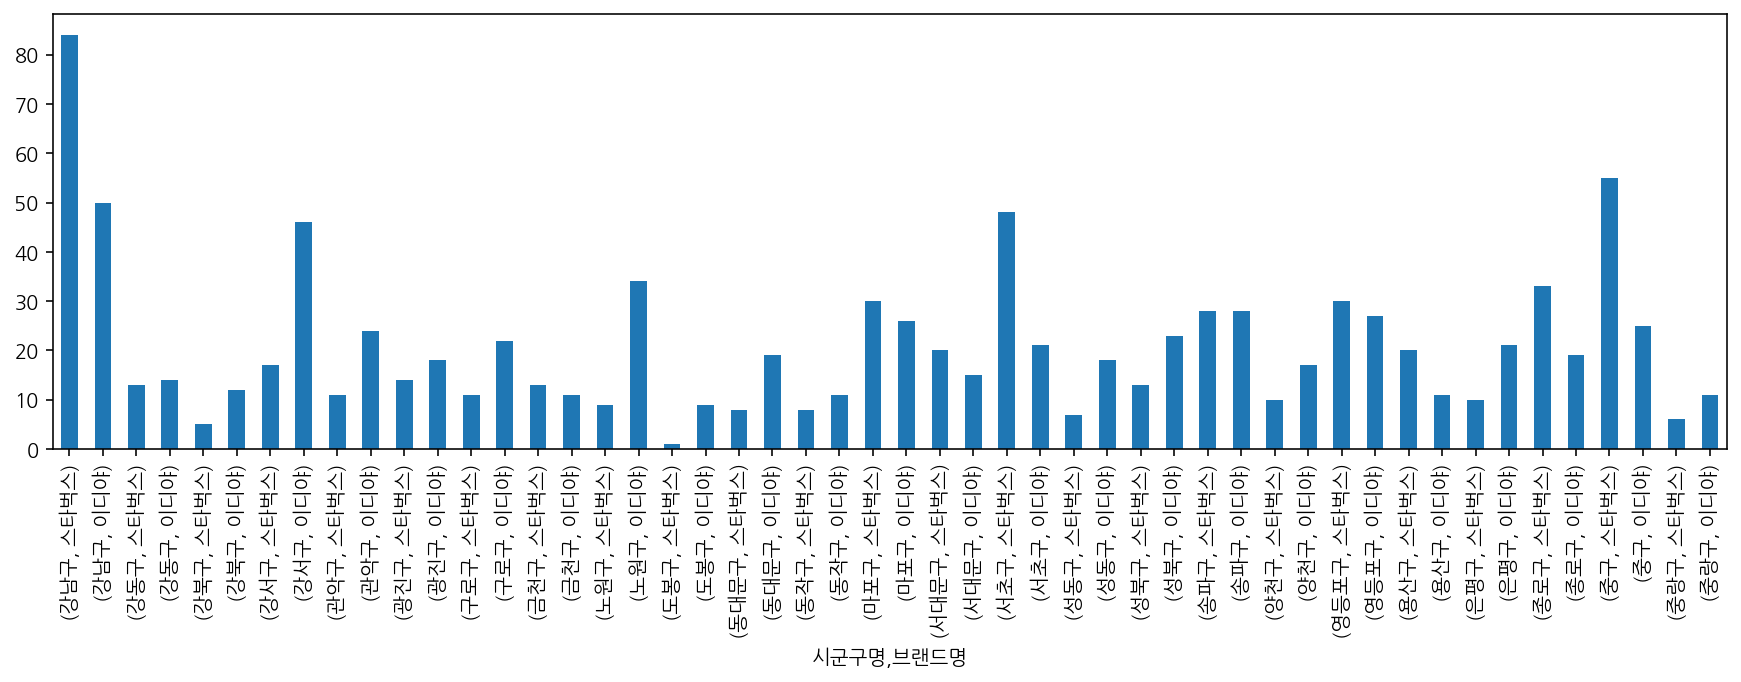

In [38]:
# groupby 를 통해 "시군구명", "브랜드명"으로 그룹화를 하고 "상호명"의 갯수를 세어봅니다.
# 갯수를 셀때는 count를 사용합니다.

group = df_cafe.groupby(['시군구명','브랜드명'])['상호명'].count()
group.plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='시군구명'>

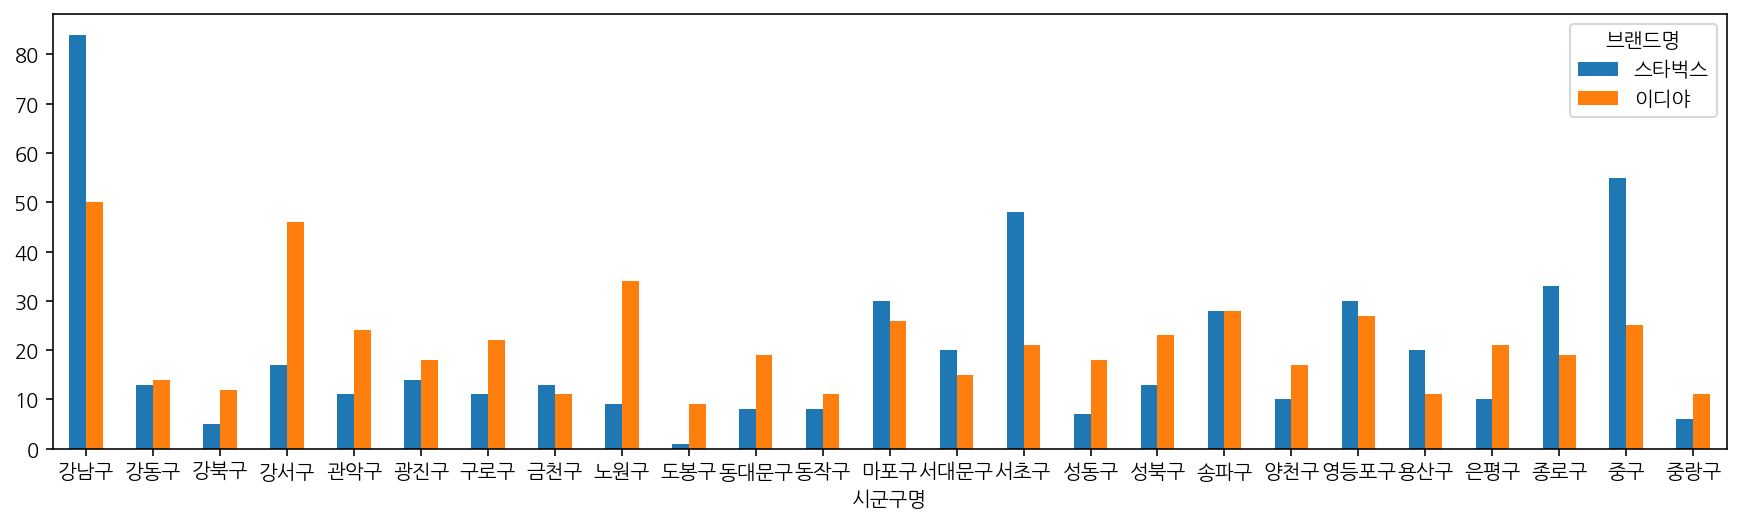

In [39]:
# 위에서 groupby 로 데이터를 집계한 결과를 시각화 합니다.
# 1. group.to_frame()
# 2. group.reset_index()
# gruopby로 묶어준 값을 다른 변수에 저장한 후 그것을 다시 .unstack()을 한 후
# .plot.bar() 를 이용하면 예쁘게 표현할 수 있다
group.unstack().plot.bar(figsize=(15,4),rot=0)

<AxesSubplot:xlabel='시군구명'>

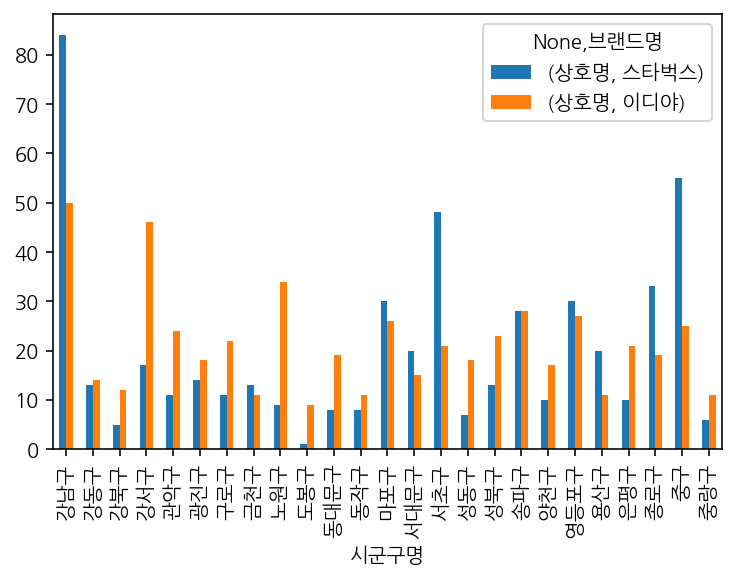

In [40]:
# pivot_table 을 이용해서 구별 스타벅스, 이디야 매장수를 구합니다.

pivot.unstack().plot.bar()

<AxesSubplot:xlabel='시군구명'>

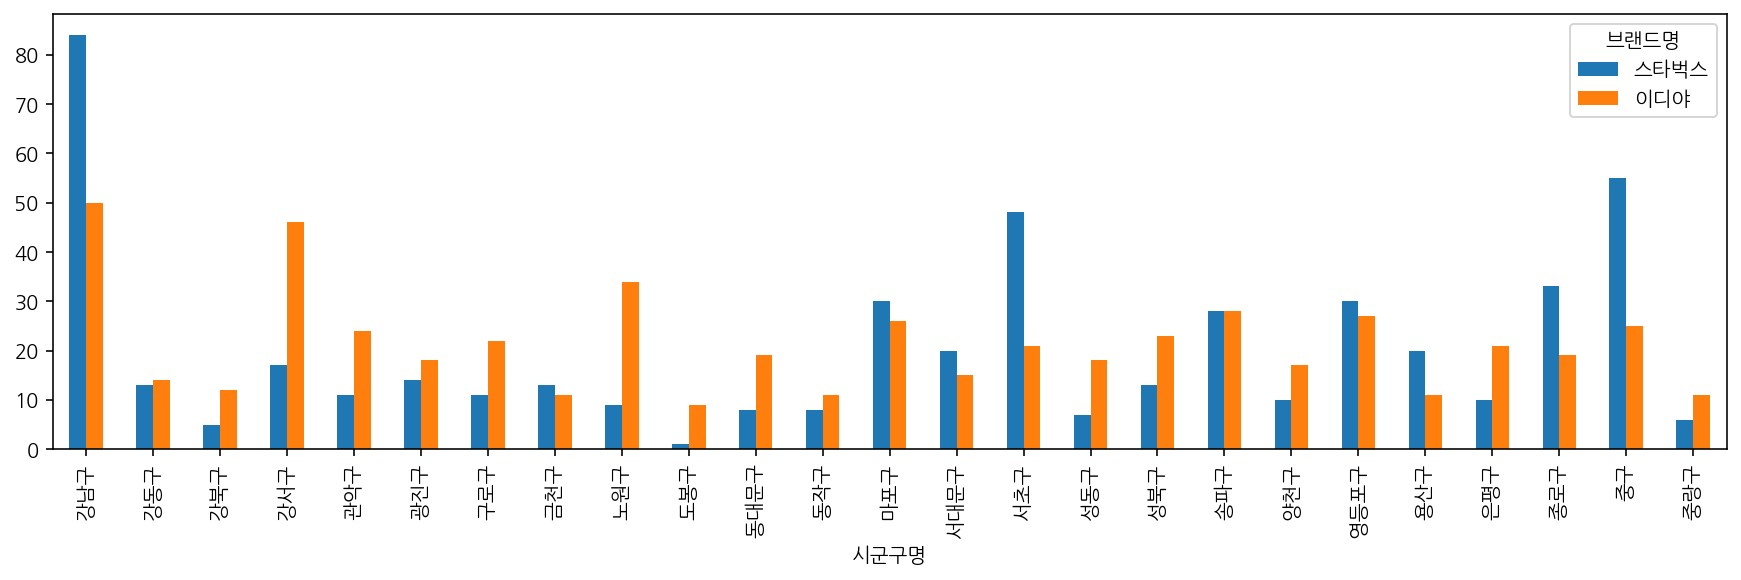

In [41]:
# 판다스의 장점 중 하나는 위에서처럼 구한 pivot_table을 시각화 해보기 쉽습니다.
# pivot_table 로 구한 결과를 plot.bar()를 통해 시각화 합니다.
pivot = pd.pivot_table(data=df_cafe,index='시군구명', 
               columns='브랜드명',values='상호명',
               aggfunc='count')
pivot.plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='시군구명', ylabel='count'>

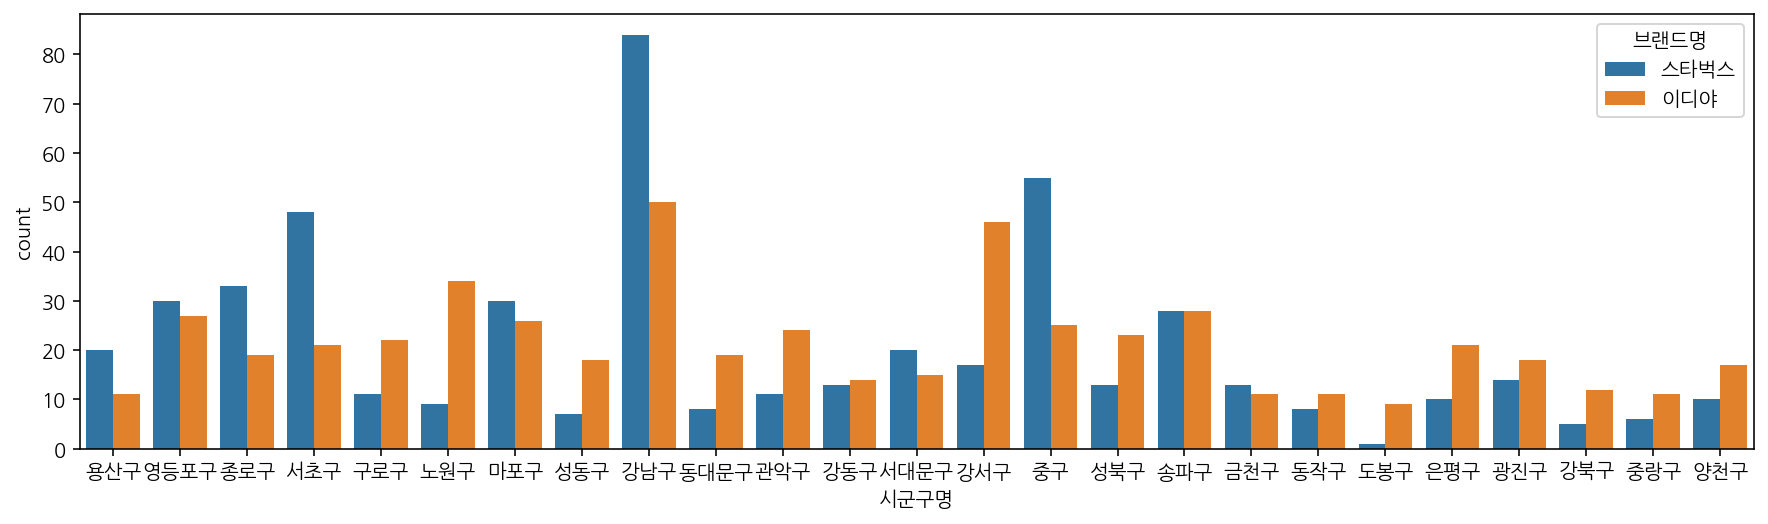

In [42]:
# Pandas 로 시각화를 하는 방법도 있지만 seaborn의 countplot을 사용하면 해당 컬럼의 수를 계산해서 시각화를 해줍니다.
# hue 옵션을 사용하게 되면 값에 따라 다른 색상으로 그리게 됩니다. 
# hue 옵션을 사용할 때는 2~3개 정도의 카테고리 형태의 데이터를 사용하는 것이 적합합니다.
# 여기에서는 브랜드명에 따라 다른 색상으로 표시할 수 있도록 합니다.

plt.figure(figsize=(15,4))
sns.countplot(data=df_cafe,x='시군구명',hue='브랜드명')

## Folium 으로 지도 활용하기
* 다음의 프롬프트 창을 열어 conda 명령어로 설치합니다.
<img src="https://i.imgur.com/x7pzfCP.jpg">

* <font color="red">주피터 노트북 상에서 설치가 되지 않으니</font> anaconda prompt 를 열어서 설치해 주세요.


* 윈도우
    * <font color="red">관리자 권한</font>으로 아나콘다를 설치하셨다면 다음의 방법으로 anaconda prompt 를 열어 주세요.
    <img src="https://i.imgur.com/GhoLwsd.png">
* 맥
    * terminal 프로그램을 열어 설치해 주세요. 



* 다음의 문서를 활용해서 지도를 표현합니다.
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/main/examples/Quickstart.ipynb
* Folium 사용예제 :
http://nbviewer.jupyter.org/github/python-visualization/folium/tree/main/examples/

In [50]:
# 아나콘다에서 folium 을 사용하기 위해서는 별도의 설치가 필요
# https://anaconda.org/conda-forge/folium
# conda install -c conda-forge folium 
# 지도 시각화를 위한 라이브러리


import folium

# 지도의 중심을 지정하기 위해 위도와 경도의 평균을 구합니다. 

lat = df_cafe['위도'].mean()
long = df_cafe['경도'].mean()

folium.Map([lat,long], zoom_start = 12)


### 스타벅스 이디야 카페 매장 전체 분포
* 스타벅스와 이디야 매장을 Marker와 CircleMarker로 지도에 표현합니다.

In [70]:
m = folium.Map([lat,long],zoom_start=12,tiles='Stamen Toner' )

for i in df_cafe.index:
    lattitude = df_cafe.loc[i,'위도']
    longitude = df_cafe.loc[i,'경도']
    name = df_cafe.loc[i,'상호명'] +' - '+ df_cafe.loc[i,'도로명주소']
    
    icon_color = 'blue'
    if df_cafe.loc[i,'브랜드명'] == '스타벅스':
        icon_color = 'green'
    
    folium.CircleMarker([lattitude, longitude], 
             tooltip = name,
            radius = 3,
            color = icon_color
              ).add_to(m)
    
m

### choropleth 를 위한 GeoJSON 파일로드

* 구별로 매장수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)
    * 이 링크에서도 다운로드가 가능합니다. https://drive.google.com/open?id=13j8-_XLdPe0pptsqu8-uyE-0Ym6V2jw5
    
* Choropleth-maps : https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

In [81]:
# 서울의 행정구역 경계를 GeoJSON으로 표현한 파일입니다. 
# 이 파일을 불러와 구별 스타벅스와 이디야의 매장수를 표현합니다.
geo_path = '../seoul_municipalities_geo_simple.json'

import json
geo_json = json.load(open(geo_path, encoding="utf-8"))

geo_json['features'][0]['properties']['name']

'강동구'

### 스타벅스 매장 분포

In [87]:
# df_cafe_vs 변수에 담긴 값을 통해 스타벅스의 매장 수를 구합니다.
# "브랜드명"컬럼으로 스타벅스만 가져옵니다.


df_star = df_cafe_vs[df_cafe_vs['브랜드명'] == '스타벅스'].copy()
df_star.head()

,구,브랜드명,매장수
0,강남구,스타벅스,84
2,강동구,스타벅스,13
4,강북구,스타벅스,5
6,강서구,스타벅스,17
8,관악구,스타벅스,11


In [92]:
# geo_json 에서 구 이름 가져오기


geo_json['features'][0]['properties']['name']

    

'강동구'

In [98]:
# df_cafe_starbucks 로 스타벅스 매장 수 구하기
# choropleth의 색상은 fill_color = 'YlGn'을 사용합니다.

m = folium.Map([lat,long],zoom_start = 12,tiles='Stamen Toner')


folium.Choropleth(
    geo_data=geo_json,
    data=df_star,
    columns=["구", "매장수"],
    key_on="feature.properties.name",
    fill_opacit = 0.7,
    line_opacity = 0.2,
    fill_color="YlGn",
    legend_name='스타벅스 매장수'
).add_to(m)

m

### 이디야 매장 분포

In [101]:
# 이디야의 매장 수를 구합니다.
# "브랜드명"컬럼으로 이디야만 가져옵니다.

df_e = df_cafe_vs[df_cafe_vs['브랜드명'] == '이디야'].copy()
df_e.head()

,구,브랜드명,매장수
1,강남구,이디야,50
3,강동구,이디야,14
5,강북구,이디야,12
7,강서구,이디야,46
9,관악구,이디야,24


In [106]:
m = folium.Map([lat,long],zoom_start=12,tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    data=df_e,
    columns=["구", "매장수"],
    key_on="feature.properties.name",
    fill_opacit = 0.7,
    line_opacity = 0.2,
    fill_color='Blues',
    legend_name='이디야 매장수'
).add_to(m)

for i in df_cafe.index:
    lattitude = df_cafe.loc[i,'위도']
    longitude = df_cafe.loc[i,'경도']
    name = df_cafe.loc[i,'상호명'] +' - '+ df_cafe.loc[i,'도로명주소']
    
    icon_color = 'blue'
    if df_cafe.loc[i,'브랜드명'] == '스타벅스':
        icon_color = 'green'
    
    folium.CircleMarker([lattitude, longitude], 
             tooltip = name,
            radius = 3,
            color = icon_color
              ).add_to(m)

m

### 매장수 크기를 반영해 CircleMaker 그리기
* Pandas 의 reshaping data 활용하기

<img src="https://i.imgur.com/IIhU0nF.png">

* 출처 : https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
* reshaping 관련 문서 : https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

In [111]:
# df_vs 라는 변수에 구별 브랜드명을 pivot해서 스타벅스와 이디야 매장을 비교할 수 있는 형태로 만듭니다.
# 그리고 ["스타벅스", "이디야"] 로 컬럼명을 변경해주고 
# 스타벅스와 이디야의 매장을 비교한 값을 "매장수비교" 컬럼에 담아줍니다.

# pivot을 사용할 때는 굳이 .copy()를 사용하지 않아도 됨

df_vs = df_cafe_vs.pivot(index='구',columns ='브랜드명',values='매장수')
df_vs['매장수비교'] = df_vs['스타벅스'] - df_vs['이디야'] >0
df_vs.head()

브랜드명,스타벅스,이디야,매장수비교
구,,,
강남구,84,50,True
강동구,13,14,False
강북구,5,12,False
강서구,17,46,False
관악구,11,24,False


In [114]:
# 간단한 함수를 사용해서 스타벅스가 이디야보다 매장수가 많을 때 1을 출력하도록 합니다.
# chororpleth 에서 radius를 사용할 때, float 타입으로 해야 오류가 나지 않는다

df_vs['매장수비교'] = df_vs['매장수비교'].astype(float)
df_vs.head()

브랜드명,스타벅스,이디야,매장수비교
구,,,
강남구,84,50,1.0
강동구,13,14,0.0
강북구,5,12,0.0
강서구,17,46,0.0
관악구,11,24,0.0


In [116]:
# 구를 컬럼명으로 사용하기 위해 reset_index 를 합니다.
# 데이터 프레임을 df_vs 에 저장합니다.
df_vs = df_vs.reset_index()
df_vs

브랜드명,구,스타벅스,이디야,매장수비교
0,강남구,84,50,1.0
1,강동구,13,14,0.0
2,강북구,5,12,0.0
3,강서구,17,46,0.0
4,관악구,11,24,0.0
5,광진구,14,18,0.0
6,구로구,11,22,0.0
7,금천구,13,11,1.0
8,노원구,9,34,0.0
9,도봉구,1,9,0.0


### Choropleth 로 매장수의 많고 적음에 따라 표현하기

In [121]:
for i in df_vs.index:
    print(df_vs.loc[i, '구'])

강남구
강동구
강북구
강서구
관악구
광진구
구로구
금천구
노원구
도봉구
동대문구
동작구
마포구
서대문구
서초구
성동구
성북구
송파구
양천구
영등포구
용산구
은평구
종로구
중구
중랑구


In [119]:
# 스타벅스 매장 수 구하기
# choropleth의 색상은 fill_color = 'BuGn'을 사용합니다.
# CircleMarker의 radius 지정시 int 타입일 때 다음과 같은 타입오류가 나서 
# float type 으로 변경이 필요합니다.
# TypeError: Object of type 'int64' is not JSON serializable

m = folium.Map([lat,long],zoom_start=12,tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    data=df_vs,
    columns=["구", "매장수비교"],
    key_on="feature.properties.name",
    fill_opacit = 0.7,
    line_opacity = 0.2,
    fill_color='BuGn',
    legend_name='매장수비교'
).add_to(m)



m

In [126]:
df_gu_mean = df_cafe.pivot_table(index = '시군구명', values=['경도','위도'], aggfunc='mean')
df_gu_mean = df_gu_mean.reset_index()
df_gu_mean.head()

,시군구명,경도,위도
0,강남구,127.046129,37.505744
1,강동구,127.135417,37.540316
2,강북구,127.022897,37.631146
3,강서구,126.837883,37.555966
4,관악구,126.935210,37.482054


In [128]:
df_vs = df_vs.merge(df_gu_mean, how='inner', left_on='구', right_on='시군구명')
df_vs.head()

,구,스타벅스,이디야,매장수비교,시군구명,경도,위도
0,강남구,84,50,1.0,강남구,127.046129,37.505744
1,강동구,13,14,0.0,강동구,127.135417,37.540316
2,강북구,5,12,0.0,강북구,127.022897,37.631146
3,강서구,17,46,0.0,강서구,126.837883,37.555966
4,관악구,11,24,0.0,관악구,126.935210,37.482054


In [131]:
# 구별로 CircleMarker를 표현하기 위해서는 각 구의 위경도 값을 구해야 합니다.
# 구별 위도와 경도를 가져와 평균 값을 구해서 사용합니다.
# 특정 구의 위경도의 평균을 구합니다.


for i in df_vs.index:
    sub_lat = df_vs.loc[i,'위도']
    sub_long = df_vs.loc[i,'경도']
    print(df_vs.loc[i,'구'], sub_lat, sub_long)


강남구 37.50574379723648 127.04612924851483
강동구 37.540316128928005 127.13541705768309
강북구 37.63114579912596 127.02289728220342
강서구 37.555966339807725 126.83788319929005
관악구 37.482054429288624 126.93521011850085
광진구 37.543769718110475 127.08329747837425
구로구 37.49406074774298 126.87745596750014
금천구 37.46928692765211 126.89219622133886
노원구 37.64239330513539 127.06717137772726
도봉구 37.66576544822702 127.04047354226729
동대문구 37.580700635471146 127.0549281321253
동작구 37.49570035386574 126.94890217041826
마포구 37.55548154197543 126.92300493503947
서대문구 37.566284229288875 126.93762476470604
서초구 37.493010911046724 127.01402160112261
성동구 37.55457943854072 127.03635911128876
성북구 37.59886024576221 127.02565170180027
송파구 37.5011799146096 127.1141353230951
양천구 37.52891847594385 126.86196683493063
영등포구 37.520781009585264 126.91390000535674
용산구 37.53468952777027 126.98251254628539
은평구 37.61406806596294 126.92041650466945
종로구 37.57615434804085 126.98723628325016
중구 37.56289726978086 126.986573350736
중랑구 37.5960

### 신문기사와 유사하게 매장수에 따라 원의 크기를 다르게 그리기
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/main/examples/Colormaps.ipynb

In [152]:
m = folium.Map([lat,long],zoom_start=12,tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    data=df_vs,
    columns=["구", "매장수비교"],
    key_on="feature.properties.name",
    fill_opacit = 0.7,
    line_opacity = 0.2,
    fill_color='BuGn',
    legend_name='매장수비교'
).add_to(m)

for i in df_vs.index:
    sub_lat = df_vs.loc[i,'위도']
    sub_long = df_vs.loc[i,'경도']
    cafes = ['스타벅스','이디야']
    
    for cafe in cafes:
        cafe_count = df_vs.loc[i,cafe]
        radius = np.sqrt(cafe_count) *3
        
        gu = df_vs.loc[i,'구']
        tooltip=f'{gu}{cafe} : {cafe_count}'
        
        icon_color = 'green'
        if cafe =='이디야':
            icon_color = 'blue'
            sub_long = sub_long + 0.1
        folium.CircleMarker([sub_lat,sub_long],
                            radius=float(radius),
                            color = icon_color,
                            fill=True,
                            tooltip = tooltip
                       ).add_to(m)
m

In [ ]:
# 아래의 for문을 활용해서  스타벅스, 이디야로 매장수를 반영해 그리도록 합니다.
# choropleth의 색상은 fill_color = 'BuGn'을 사용합니다.
# CircleMarker 의 radius 크기를 구해서 원의 크기를 다르게 표현해 봅니다.
# 또, 경도에 특정 숫자를 더해 두 개의 원이 겹치지 않게 그려봅니다.


* 카토그램
    * [총선⑫ 인구 비례로 본 당선 지도…‘카토그램’으로 살펴본 당선 현황 > 데이터룸 > 정치 > 뉴스 | KBSNEWS](http://news.kbs.co.kr/news/view.do?ncd=3264019)
    * [The Housing Value of Every County in the U.S. - Metrocosm](http://metrocosm.com/the-housing-value-of-every-county-in-the-u-s/)